# Awkward Array updates

**Note:** although I'm presenting in Jupyter, this is a talk, rather than a tutorial. You don't have to follow along.

<br><br><br><br><br>

## Awkward 2.0: time for a new version!

However,

   * we are _not_ repeating the name-switch fiasco
   * we are _not_ changing the data analyst interface (much)
   * the biggest visible difference is how lazy arrays are managed

<img src="img/awkward-timeline.png" width="100%">

<br><br><br><br><br>

# How close is it to being finished?

By counting expected lines of code, 95% done.

It's usable now with "rough edges." Try it out:

```python
import awkward._v2 as ak
```

<br><br><br><br><br>

## How did the Awkward 0 → Awkward 1 transition go?

It's almost done: more pip-installs of 1.x than 0.x, in batch jobs and laptops.

<table width="100%"><tr style="background: white">
    <td align="left" width="50%"><img src="img/pip-allos-awkward-lin.png" width="98%"></td>
    <td align="right" width="50%"><img src="img/pip-macwin-awkward-lin.png" width="98%"></td>
</tr></table>

<br><br><br><br><br>

## Why change it at all?

Awkward 1.x moved loops over arrays from NumPy to specialized compiled "kernels." That was good.

It also moved the implementation of Awkward's tree structures into C++. That was bad.

[This talk has all the details](https://indico.cern.ch/event/855454/contributions/4605044/), but we needed to reimplement Awkward tree manipulation back into Python to make it more transparent to other Python libraries.

<table width="100%"><tr style="background: white">
    <td align="center" width="50%" style="font-size: 14pt; font-weight: bold">Architecture of Awkward 1.x</td>
    <td align="center" width="50%" style="font-size: 14pt; font-weight: bold">Architecture of Awkward 2.x</td>
</tr><tr style="background: white">
    <td align="left" width="50%"><img src="img/awkward-1-layers-problem.png" width="100%"></td>
    <td align="right" width="50%"><img src="img/awkward-2-layers-solution.png" width="100%"></td>
</tr></table>

<br><br><br><br><br>

## What about performance?

Only the "kernels" level of Awkward's architecture is relevant for the performance of _O(n)_ algorithms, and that's still compiled.

Moving the tree structures into Python can actually improve performance for a hundred little reasons.

Consider this array:

```python
array = ak.Array([
    [{"x": 1.1, "y": [1]}, {"x": 2.2, "y": [1, 2]}, {"x": 3.3, "y": [1, 2, 3]}],
    [],
    [{"x": 4.4, "y": [1, 2, 3, 4]}, {"x": 5.5, "y": [1, 2, 3, 4, 5]}]
] * 1000000)
```

and this calculation (from the front page of Awkward's GitHub page):

```python
output = np.square(array_v2["y", ..., 1:])
```

<br>

In [1]:
import numpy as np

In [2]:
import awkward as ak

### With version 2.x:

In [3]:
array_v2 = ak._v2.from_parquet("data/simple-30-million.parquet")

In [4]:
array_v2

<Array [[{x: 1.1, y: [1]}, ..., {x: 3.3, ...}], ...] type='30000000 * var *...'>

In [5]:
%%timeit -n 1 -r 3

output = np.square(array_v2["y", ..., 1:])

1.41 s ± 24 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)


In [6]:
del array_v2

<br>

### With version 1.x:

In [7]:
array_v1 = ak.from_parquet("data/simple-30-million.parquet")

In [8]:
%%timeit -n 1 -r 3

output = np.square(array_v1["y", ..., 1:])

2.37 s ± 32.7 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)


<br>

### With version 0.x:

In [9]:
array_v0 = ak.to_awkward0(array_v1)

/home/jpivarski/irishep/OLD/awkward-0.x/awkward0/__init__.py:8: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if distutils.version.LooseVersion(numpy.__version__) < distutils.version.LooseVersion("1.13.1"):


In [10]:
%%timeit -n 1 -r 3

output = np.square(array_v0["y"][:, 1:])

/home/jpivarski/irishep/OLD/awkward-0.x/awkward0/array/base.py:622: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif isinstance(where, (cls.numpy.ndarray, AwkwardArray)) and issubclass(where.dtype.type, (numpy.str, numpy.str_)):
/home/jpivarski/irishep/OLD/awkward-0.x/awkward0/array/base.py:624: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif isinstance(where, (cls.numpy.ndarray, AwkwardArray)) and issubclass(

6.03 s ± 853 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)


In [11]:
del array_v1, array_v0

<br><br><br>

| | time (sec) |
|:-|:-:|
| Awkward v2 | 1.5 |
| Awkward 1.8.0 | 2.4 |
| Awkward 0.15.5 | 6.0 |
| equivalent Python | 140.0 |

<br><br><br>

## What about interoperability with C++?

Originally, I thought we would link C++ libraries directly to libawkward.so, after some experience, this doesn't seem credible.

Much better ideas:

   * pass array buffers between Python and C or C++, as fastjet does (previous talk)
   * JIT-compile the connection between Awkward Array and C++

<br><br><br><br><br>

In [3]:
import ROOT

Welcome to JupyROOT 6.24/04


In [4]:
array = ak._v2.Array([
    [{"x": 1.1, "y": [1]}, {"x": 2.2, "y": [1, 2]}, {"x": 3.3, "y": [1, 2, 3]}],
    [],
    [{"x": 4.4, "y": [1, 2, 3, 4]}, {"x": 5.5, "y": [1, 2, 3, 4, 5]}]
])
array

<Array [[{...}, ..., {...}], ...] type='3 * var * {x: float64, y: var * int64}'>

Low-level stuff that would be hidden in real applications:

In [6]:
import awkward._v2._connect.cling

generator = ak._v2._connect.cling.togenerator(array.layout.form)

lookup = ak._v2._lookup.Lookup(array.layout)

generator.generate(ROOT.gInterpreter.Declare)

Here's a C++ function that iterates over the Awkward Array:

In [6]:
ROOT.gInterpreter.Declare(f"""
void run_1(ssize_t length, ssize_t* ptrs) {{
    auto awkward_array = {generator.dataset()};

    std::cout << "[" << std::endl;
    for (auto list : awkward_array) {{
        std::cout << "    [" << std::endl;
        if (list.size() == 0) {{
            std::cout << "        (empty!)" << std::endl;
        }}
        for (auto record : list) {{
            std::cout << "        {{" << std::endl;
            std::cout << "            x: " << record.x() << std::endl;
            std::cout << "            y: ";
            for (auto item : record.y()) {{
                std::cout << item << " ";
            }}
            std::cout << "" << std::endl;
            std::cout << "        }}" << std::endl;
        }}
        std::cout << "    ]" << std::endl;
    }}
    std::cout << "]" << std::endl;
}}
""")

True

In [7]:
ROOT.run_1(len(array), lookup.arrayptrs)

[
    [
        {
            x: 1.1
            y: 1 
        }
        {
            x: 2.2
            y: 1 2 
        }
        {
            x: 3.3
            y: 1 2 3 
        }
    ]
    [
        (empty!)
    ]
    [
        {
            x: 4.4
            y: 1 2 3 4 
        }
        {
            x: 5.5
            y: 1 2 3 4 5 
        }
    ]
]


<br><br><br>

This feature is being developed for an Awkward Array ↔ RDataFrame bridge.

<br><br><br><br><br>

## Does it scale? Sort of.

The Awkward C++ iterators use exactly the same strategy (and some of the same code) as Awkward Numba iterators.

In [ ]:
del array, lookup

In [3]:
array = ak._v2.from_parquet("data/simple-30-million.parquet")

In [8]:
generator = ak._v2._connect.cling.togenerator(array.layout.form)
lookup = ak._v2._lookup.Lookup(array.layout)
generator.generate(ROOT.gInterpreter.Declare)

In [9]:
ROOT.gInterpreter.ProcessLine(".O3")  # this definitely changes the optimization level

ROOT.gInterpreter.Declare(f"""
double fast_1(ssize_t length, ssize_t* ptrs) {{
    auto awkward_array = {generator.dataset()};
    double out = 0.0;

    for (auto list : awkward_array) {{
        for (auto record : list) {{
            for (auto item : record.y()) {{
                out += item;
            }}
        }}
    }}
    
    return out;
}}
""")

True

In [10]:
%%timeit -n 1 -r 3

ROOT.fast_1(len(array), lookup.arrayptrs)

3.14 s ± 21 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)


In [11]:
import numba as nb

In [12]:
ak._v2.numba.register()

In [13]:
@nb.njit
def fast(array):
    out = 0.0
    for nested_list in array:
        for record in nested_list:
            for item in record.y:
                out += item
    return out

In [14]:
%%timeit -n 1 -r 3

fast(array)

339 ms ± 145 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)


<br><br><br>

But there's still a factor of ~10 in Numba's favor.

Bracketing the problem: a standalone Cling (from the [compiler-research.org](https://compiler-research.org/) group) exactly reproduces Numba's rate, so it's something that we don't understand in ROOT.

<br><br><br><br><br>

In [4]:
array_gpu = ak._v2.to_backend(array, "cuda")

In [5]:
output_gpu = np.sqrt(ak._v2.num(array_gpu["y"], axis=2))

In [6]:
ak._v2.to_backend(output_gpu, "cpu")

<Array [[1, 1.41, 1.73], [], ..., [2, 2.24]] type='30000000 * var * float64'>

In [7]:
del array_gpu, output_gpu

Here's what the above looks like in Nvidia's profiler (not live):

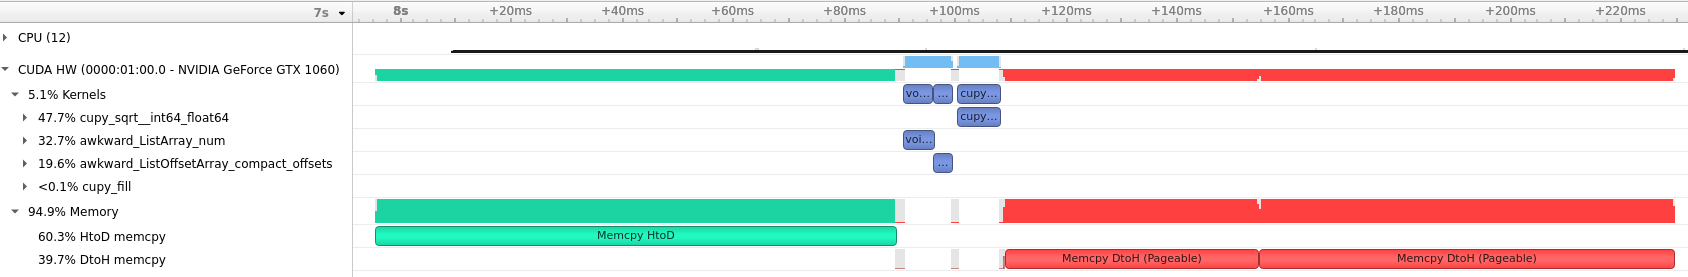

Zooming in to the kernels calls between the host-to-device copy (HtoD) and device-to-host copy (DtoH):

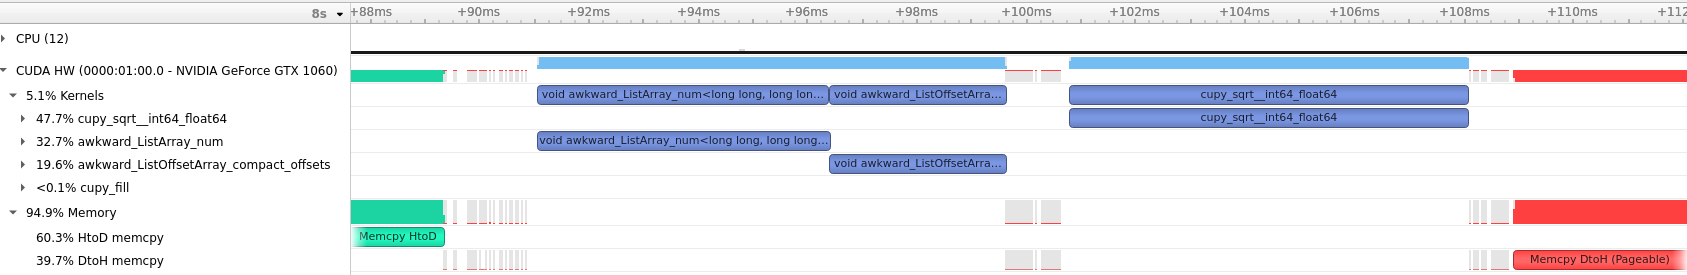

The actual GPU computation runs in 108 ‒ 91 ms = 17 ms.

On the CPU:

In [8]:
%%timeit -n 1 -r 3

output_cpu = np.sqrt(ak._v2.num(array["y"], axis=2))

201 ms ± 6.53 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
